In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from scipy.fftpack import dct, idct
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import time

## Create the reduced MNIST dataset
- The original MNIST dataset has 60,000 training images and 10,000 test images.
- We will create a reduced dataset with 10,000 training images(1000 for each digit) and 2,000 test images (200 for each digit).

In [4]:
# Function to create ReducedMNIST
def create_reduced_mnist(X, y, train_per_digit=1000, test_per_digit=200):
    X_train, X_test, y_train, y_test = [], [], [], []
    for digit in range(10):
        # Get indices of all images for this digit
        digit_indices = np.where(y == digit)[0]
        # Shuffle indices to randomize selection
        np.random.shuffle(digit_indices)
        # Split into training and testing indices
        train_indices = digit_indices[:train_per_digit]
        test_indices = digit_indices[train_per_digit:train_per_digit + test_per_digit]
        # Append data and labels
        X_train.append(X[train_indices])
        X_test.append(X[test_indices])
        y_train.append(y[train_indices])
        y_test.append(y[test_indices])
    # Stack into single arrays
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, y_train, X_test, y_test

In [7]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1,as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)

# Create reduced MNIST dataset
X_train, y_train, X_test, y_test = create_reduced_mnist(X, y)


# Normalize data
X_train = X_train / 255.0
X_test = X_test / 255.0


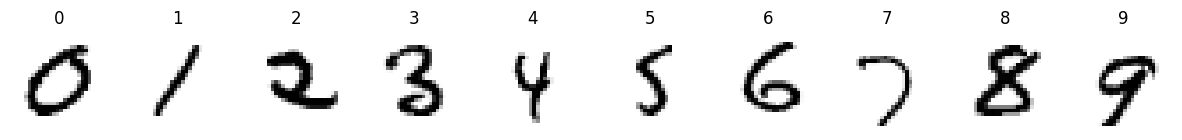

In [ ]:
# Plot some images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i in range(10):
    ax = axes[i]
    # Find the first image of each class
    idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[idx].reshape(28, 28), cmap='binary')
    ax.axis('off')
    ax.set_title(i)
plt.show()



## DCT 
- The Discrete Cosine Transform (DCT) is a technique used in image compression.
- The DCT is similar to the Discrete Fourier Transform (DFT) but uses only real numbers.
- The DCT is used in JPEG image compression.


In [ ]:
def extract_dct_features(X,n_components=225):
    sqrt_img = int(np.sqrt(X.shape[1]))
    sqrt_n = int(np.sqrt(n_components))
    dct_features = []
    for img in X:
        # Reshape image to 2D from 1D-array
        img = img.reshape(sqrt_img,sqrt_img)
        
        # Apply 2D DCT
        dct_img = dct(dct(img,axis=0, norm='ortho'),axis=1, norm='ortho')

        # Extract top-left sqrt_n x sqrt_n coefficients
        dct_features.append(dct_img[:sqrt_n,:sqrt_n].flatten())

    return np.array(dct_features)


# Function to reconstruct image from DCT features
def reconstruct_from_dct(dct_features, original_shape=(28, 28), dct_size=15):
    dct_full = np.zeros(original_shape)
    dct_full[:dct_size, :dct_size] = dct_features.reshape(dct_size, dct_size)
    reconstructed = idct(idct(dct_full, axis=0, norm='ortho'), axis=1, norm='ortho')
    return reconstructed

In [30]:
# Extract DCT features
n_components = 225
X_train_dct = extract_dct_features(X_train, n_components)
X_test_dct = extract_dct_features(X_test, n_components)

# Reconstruct images
X_train_reconstructed_DCT = np.array([reconstruct_from_dct(x) for x in X_train_dct])
X_test_reconstructed_DCT = np.array([reconstruct_from_dct(x) for x in X_test_dct])





In [33]:

def visualize_digits(original=None, dct_reconstructed=None, pca_reconstructed=None, y=None):
    """
    Visualize one example per digit (0-9) from the MNIST dataset, showing original,
    DCT-reconstructed, and PCA-reconstructed images as separate rows.

    Parameters:
    - original: ndarray of shape (n_samples, 784) or (n_samples, 28, 28), or None
    - dct_reconstructed: ndarray of same shape as original, or None
    - pca_reconstructed: ndarray of same shape as original, or None
    - y: ndarray of shape (n_samples,), labels for each sample

    Raises:
    - ValueError: If y is None or if image shapes are invalid
    """
    # Ensure labels are provided
    if y is None:
        raise ValueError("Labels y must be provided.")

    # Collect image types to display
    image_types = []
    if original is not None:
        image_types.append(('Original', original))
    if dct_reconstructed is not None:
        image_types.append(('DCT Reconstructed', dct_reconstructed))
    if pca_reconstructed is not None:
        image_types.append(('PCA Reconstructed', pca_reconstructed))

    # If no images are provided, exit
    if not image_types:
        print("No images to display.")
        return

    # Select the first index for each digit (0-9)
    selected_indices = [np.where(y == digit)[0][0] for digit in range(10)]

    # Create figure with rows equal to number of image types and 10 columns
    fig, axes = plt.subplots(len(image_types), 10, figsize=(30, len(image_types) * 3))

    # Ensure axes is 2D even if there's only one row
    if len(image_types) == 1:
        axes = np.expand_dims(axes, axis=0)

    # Plot images for each image type and digit
    for type_index, (type_name, img_array) in enumerate(image_types):
        for digit in range(10):
            ax = axes[type_index, digit]
            idx = selected_indices[digit]
            img = img_array[idx]

            # Reshape image if necessary
            if img.ndim == 1 and img.size == 784:
                img = img.reshape(28, 28)
            elif img.shape != (28, 28):
                raise ValueError(f"Image for {type_name} must be of shape (28, 28) or (784,)")

            # Display the image
            ax.imshow(img, cmap='gray')

            # Add digit labels above the first row
            if type_index == 0:
                ax.set_title(f'Digit {digit}')

            # Remove axes
            ax.axis('off')

    # Add image type labels to the left of each row
    for type_index, (type_name, _) in enumerate(image_types):
        ax = axes[type_index, 0]
        ax.text(-0.1, 0.5, type_name, transform=ax.transAxes, fontsize=12, 
                va='center', ha='right')

    # Adjust layout to make space for row labels
    fig.subplots_adjust(left=0.15)
    plt.show()

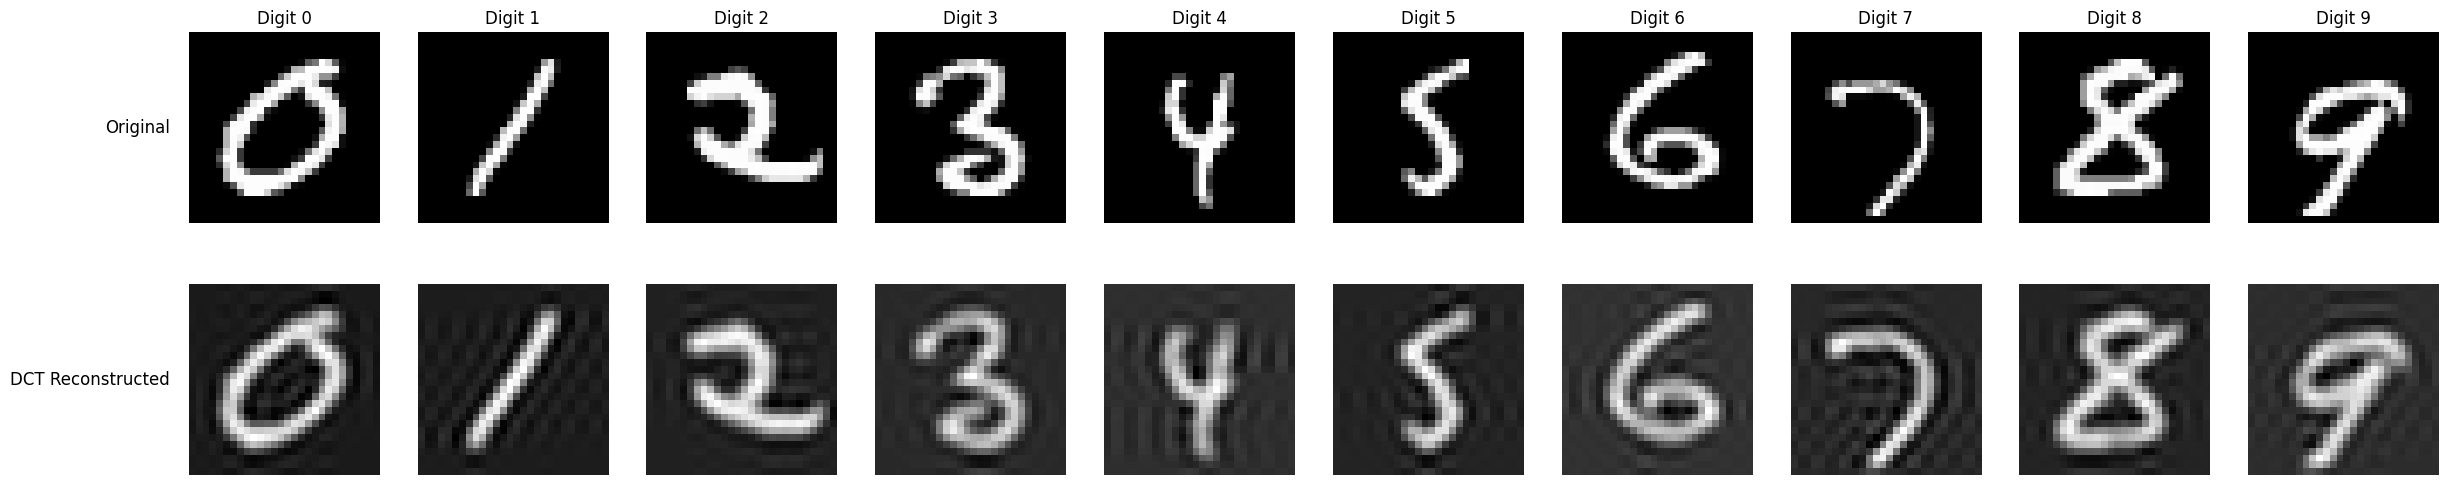

In [34]:
visualize_digits(original=X_train, dct_reconstructed=X_train_reconstructed_DCT, pca_reconstructed=None, y=y_train)

## PCA 
- Principal Component Analysis (PCA) is a technique used for dimensionality reduction.
- PCA finds the directions (principal components) in which the data has the most variance.
- The principal components are orthogonal to each other.
- The principal components are sorted by the amount of variance they explain.



Original number of dimensions: 784, PCA number of dimensions: 152


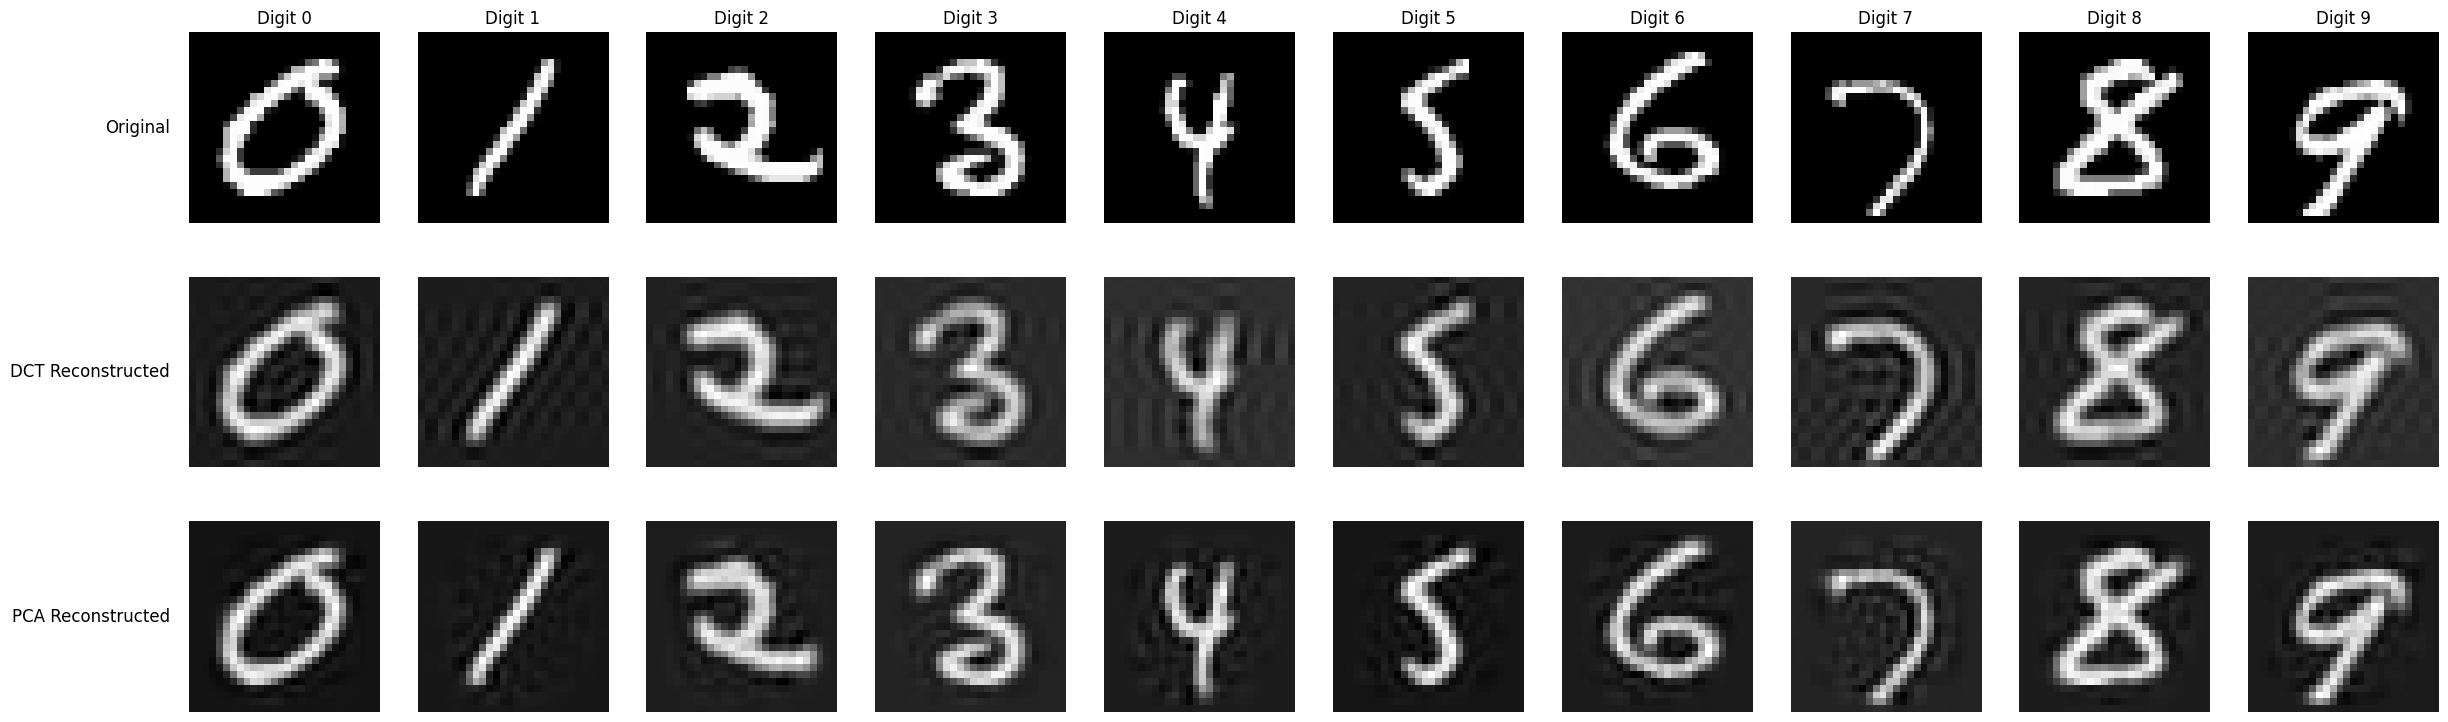

In [64]:

# Apply PCA to Original Data
variance = 0.95
pca = PCA(n_components=variance)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original number of dimensions: {X_train.shape[1]}, PCA number of dimensions: {X_train_pca.shape[1]}")

# Reconstruct images
X_train_reconstructed_PCA = pca.inverse_transform(X_train_pca)
X_test_reconstructed_PCA = pca.inverse_transform(X_test_pca)

visualize_digits(original=X_train, dct_reconstructed=X_train_reconstructed_DCT, pca_reconstructed=X_train_reconstructed_PCA, y=y_train)



## Training a classifier 
### a-First We will try to train `k-means with [1,4,16,32] clusters` for each class

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import numpy as np
import time

def kmeans_per_class(X_train, y_train, X_test, y_test, n_clusters_list):
    results = []
    best_model = None
    best_accuracy = -1
    best_n_clusters = None
    
    for n_clusters in n_clusters_list:
        print(f"\nTraining K-means with {n_clusters} clusters per class...")
        
        # Start timing training
        train_start_time = time.time()
        
        # Train K-means for each class
        kmeans_models = {}
        for digit in range(10):
            digit_indices = np.where(y_train == digit)[0]
            X_digit = X_train[digit_indices]
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            kmeans.fit(X_digit)
            kmeans_models[digit] = kmeans
        
        train_time = time.time() - train_start_time
        
        # Start timing prediction
        pred_start_time = time.time()
        
        # Predict by finding the closest centroid across all classes
        y_pred = []
        for test_sample in X_test:
            min_dist = float('inf')
            predicted_digit = 0
            for digit in range(10):
                kmeans = kmeans_models[digit]
                distances = np.linalg.norm(test_sample - kmeans.cluster_centers_, axis=1)
                closest_dist = distances.min()
                if closest_dist < min_dist:
                    min_dist = closest_dist
                    predicted_digit = digit
            y_pred.append(predicted_digit)
        
        pred_time = time.time() - pred_start_time
        total_time = train_time + pred_time
        
        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            'n_clusters': n_clusters,
            'accuracy': accuracy,
            'train_time': train_time,
            'pred_time': pred_time,
            'total_time': total_time,
            'models': kmeans_models
        })
        
        # Update best model if current accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_clusters = n_clusters
            best_model = kmeans_models  # Store the dictionary of K-means models for the best configuration
        
        print(f"n_clusters={n_clusters}: Accuracy={accuracy:.4f}, Total Time={total_time:.2f}s")
    
    return {
        'best_model': best_model,
        'best_n_clusters': best_n_clusters,
        'best_accuracy': best_accuracy,
        'results': results
    }

# Example usage
n_clusters_list = [1, 4, 16, 32]
kmeans_dct_result = kmeans_per_class(X_train_dct, y_train, X_test_dct, y_test, n_clusters_list)
kmeans_pca_result = kmeans_per_class(X_train_pca, y_train, X_test_pca, y_test, n_clusters_list)

# Access the best K-means model for DCT
best_kmeans_dct = kmeans_dct_result['best_model']
best_kmeans_dct_n_clusters = kmeans_dct_result['best_n_clusters']
best_kmeans_dct_accuracy = kmeans_dct_result['best_accuracy']
print(f"\nBest K-means (DCT): {best_kmeans_dct_n_clusters} clusters, Accuracy={best_kmeans_dct_accuracy:.4f}")

# Access the best K-means model for PCA
best_kmeans_pca = kmeans_pca_result['best_model']
best_kmeans_pca_n_clusters = kmeans_pca_result['best_n_clusters']
best_kmeans_pca_accuracy = kmeans_pca_result['best_accuracy']
print(f"Best K-means (PCA): {best_kmeans_pca_n_clusters} clusters, Accuracy={best_kmeans_pca_accuracy:.4f}")


Training K-means with 1 clusters per class...


n_clusters=1: Accuracy=0.7975, Total Time=0.74s

Training K-means with 4 clusters per class...
n_clusters=4: Accuracy=0.8805, Total Time=1.18s

Training K-means with 16 clusters per class...
n_clusters=16: Accuracy=0.9275, Total Time=1.42s

Training K-means with 32 clusters per class...
n_clusters=32: Accuracy=0.9330, Total Time=1.70s

Training K-means with 1 clusters per class...
n_clusters=1: Accuracy=0.7980, Total Time=0.75s

Training K-means with 4 clusters per class...
n_clusters=4: Accuracy=0.8815, Total Time=1.31s

Training K-means with 16 clusters per class...
n_clusters=16: Accuracy=0.9265, Total Time=1.42s

Training K-means with 32 clusters per class...
n_clusters=32: Accuracy=0.9455, Total Time=1.67s

Best K-means (DCT): 32 clusters, Accuracy=0.9330
Best K-means (PCA): 32 clusters, Accuracy=0.9455


In [49]:
print(best_kmeans_dct)

{0: KMeans(n_clusters=32, random_state=42), 1: KMeans(n_clusters=32, random_state=42), 2: KMeans(n_clusters=32, random_state=42), 3: KMeans(n_clusters=32, random_state=42), 4: KMeans(n_clusters=32, random_state=42), 5: KMeans(n_clusters=32, random_state=42), 6: KMeans(n_clusters=32, random_state=42), 7: KMeans(n_clusters=32, random_state=42), 8: KMeans(n_clusters=32, random_state=42), 9: KMeans(n_clusters=32, random_state=42)}


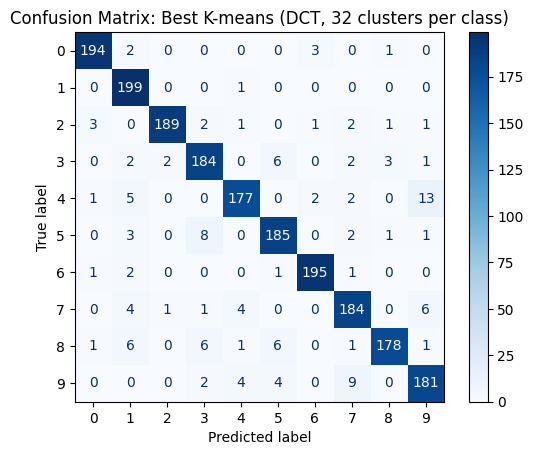

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def predict_with_kmeans(kmeans_models, X_test):
    y_pred = []
    for test_sample in X_test:
        min_dist = float('inf')
        predicted_digit = 0
        for digit in range(10):
            kmeans = kmeans_models[digit]
            distances = np.linalg.norm(test_sample - kmeans.cluster_centers_, axis=1)
            closest_dist = distances.min()
            if closest_dist < min_dist:
                min_dist = closest_dist
                predicted_digit = digit
        y_pred.append(predicted_digit)
    return np.array(y_pred)

# Predict using the best K-means model on DCT features
y_pred_kmeans_dct = predict_with_kmeans(best_kmeans_dct, X_test_dct)

# Generate confusion matrix
cm_kmeans_dct = confusion_matrix(y_test, y_pred_kmeans_dct)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans_dct, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Best K-means (DCT, 32 clusters per class)')
plt.show()

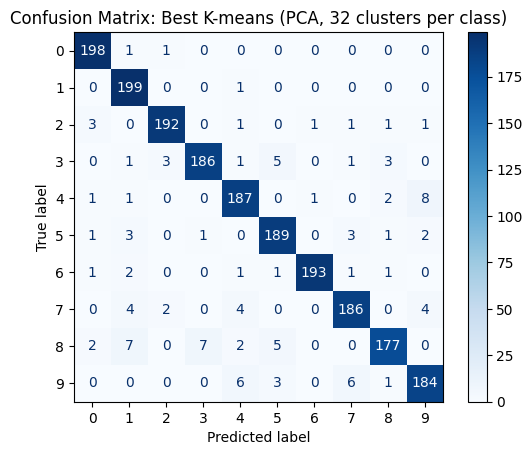

In [51]:
y_pred_kmeans_pca = predict_with_kmeans(best_kmeans_pca, X_test_pca)

# Generate confusion matrix
cm_kmeans_pca = confusion_matrix(y_test, y_pred_kmeans_pca)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_kmeans_pca, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Best K-means (PCA, 32 clusters per class)')
plt.show()

## SVM 


In [55]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

def train_svm(X_train, y_train, X_test, y_test):
    results = []
    best_model = None
    best_accuracy = -1
    best_kernel = None
    
    # List of SVM configurations with different kernels
    svm_configs = [
        ('Linear', SVC(kernel='linear', random_state=42)),
        ('RBF', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)),
        ('Polynomial (degree=2)', SVC(kernel='poly', degree=2, C=1.0, gamma='scale', random_state=42)),
        ('Polynomial (degree=3)', SVC(kernel='poly', degree=3, C=1.0, gamma='scale', random_state=42)),
        ('Sigmoid', SVC(kernel='sigmoid', gamma=0.1, coef0=0, random_state=42))
    ]
    
    for kernel_name, svm in svm_configs:
        print(f"\nTraining SVM with {kernel_name} kernel...")
        
        # Train the SVM
        train_start_time = time.time()
        svm.fit(X_train, y_train)
        train_time = time.time() - train_start_time
        
        # Predict on test set
        pred_start_time = time.time()
        y_pred = svm.predict(X_test)
        pred_time = time.time() - pred_start_time
        total_time = train_time + pred_time
        
        # Compute accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            'kernel': kernel_name,
            'accuracy': accuracy,
            'train_time': train_time,
            'pred_time': pred_time,
            'total_time': total_time,
            'model': svm
        })
        
        # Update best model if current accuracy is higher
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_kernel = kernel_name
            best_model = svm
        
        print(f"SVM ({kernel_name} Kernel): Accuracy={accuracy:.4f}, Total Time={total_time:.2f}s")
    
    return {
        'best_model': best_model,
        'best_kernel': best_kernel,
        'best_accuracy': best_accuracy,
        'results': results
    }

# Example usage
svm_dct_result = train_svm(X_train_dct, y_train, X_test_dct, y_test)
svm_pca_result = train_svm(X_train_pca, y_train, X_test_pca, y_test)

# Access the best SVM model for DCT
best_svm_dct = svm_dct_result['best_model']
best_svm_dct_kernel = svm_dct_result['best_kernel']
best_svm_dct_accuracy = svm_dct_result['best_accuracy']
print(f"\nBest SVM (DCT): {best_svm_dct_kernel} kernel, Accuracy={best_svm_dct_accuracy:.4f}")

# Access the best SVM model for PCA
best_svm_pca = svm_pca_result['best_model']
best_svm_pca_kernel = svm_pca_result['best_kernel']
best_svm_pca_accuracy = svm_pca_result['best_accuracy']
print(f"Best SVM (PCA): {best_svm_pca_kernel} kernel, Accuracy={best_svm_pca_accuracy:.4f}")


Training SVM with Linear kernel...
SVM (Linear Kernel): Accuracy=0.9250, Total Time=1.68s

Training SVM with RBF kernel...
SVM (RBF Kernel): Accuracy=0.9595, Total Time=3.18s

Training SVM with Polynomial (degree=2) kernel...
SVM (Polynomial (degree=2) Kernel): Accuracy=0.9555, Total Time=1.79s

Training SVM with Polynomial (degree=3) kernel...
SVM (Polynomial (degree=3) Kernel): Accuracy=0.9510, Total Time=2.24s

Training SVM with Sigmoid kernel...
SVM (Sigmoid Kernel): Accuracy=0.1355, Total Time=11.62s

Training SVM with Linear kernel...
SVM (Linear Kernel): Accuracy=0.9155, Total Time=1.23s

Training SVM with RBF kernel...
SVM (RBF Kernel): Accuracy=0.9690, Total Time=2.77s

Training SVM with Polynomial (degree=2) kernel...
SVM (Polynomial (degree=2) Kernel): Accuracy=0.9690, Total Time=2.00s

Training SVM with Polynomial (degree=3) kernel...
SVM (Polynomial (degree=3) Kernel): Accuracy=0.9715, Total Time=2.79s

Training SVM with Sigmoid kernel...
SVM (Sigmoid Kernel): Accuracy=0.

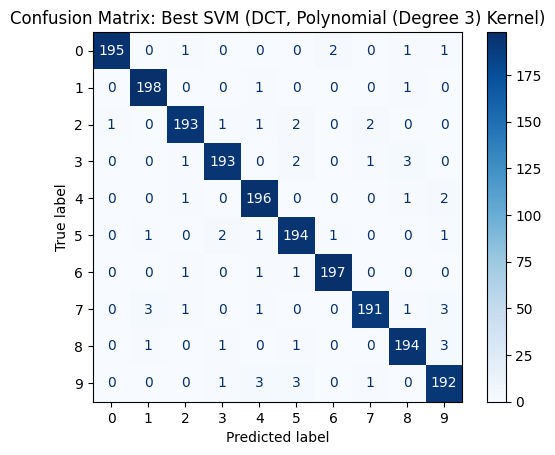

In [63]:
# Confusion matrix for best SVM (PCA)
y_pred_svm_pca = best_svm_pca.predict(X_test_pca)
cm_svm_pca = confusion_matrix(y_test, y_pred_svm_pca)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm_pca, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Best SVM (DCT, Polynomial (Degree 3) Kernel)')
plt.show()


In [59]:
# Summary Table
print("\nSummary Table:")
print("| Classifier         | Features | DCT Accuracy | DCT Processing Time | PCA Accuracy | PCA Processing Time | Best Model |")
print("|--------------------|----------|--------------|---------------------|--------------|---------------------|------------|")

# K-means results
for i, n_clusters in enumerate(n_clusters_list):
    dct_result = kmeans_dct_result['results'][i]
    pca_result = kmeans_pca_result['results'][i]
    is_best_dct = (n_clusters == kmeans_dct_result['best_n_clusters'])
    is_best_pca = (n_clusters == kmeans_pca_result['best_n_clusters'])
    best_label = ''
    if is_best_dct:
        best_label += 'DCT '
    if is_best_pca:
        best_label += 'PCA'
    best_label = best_label.strip() or '-'
    print(f"| K-means ({n_clusters} clusters) |          | {dct_result['accuracy']:.4f}       | {dct_result['total_time']:.2f}s            | {pca_result['accuracy']:.4f}       | {pca_result['total_time']:.2f}s            | {best_label} |")

# SVM results
for i, kernel in enumerate(['Linear', 'RBF','Polynomial (degree=2)', 'Polynomial (degree=3)', 'Sigmoid']):
    dct_result = svm_dct_result['results'][i]
    pca_result = svm_pca_result['results'][i]
    is_best_dct = (kernel == svm_dct_result['best_kernel'])
    is_best_pca = (kernel == svm_pca_result['best_kernel'])
    best_label = ''
    if is_best_dct:
        best_label += 'DCT '
    if is_best_pca:
        best_label += 'PCA'
    best_label = best_label.strip() or '-'
    print(f"| SVM ({kernel})       |          | {dct_result['accuracy']:.4f}       | {dct_result['total_time']:.2f}s            | {pca_result['accuracy']:.4f}       | {pca_result['total_time']:.2f}s            | {best_label} |")


Summary Table:
| Classifier         | Features | DCT Accuracy | DCT Processing Time | PCA Accuracy | PCA Processing Time | Best Model |
|--------------------|----------|--------------|---------------------|--------------|---------------------|------------|
| K-means (1 clusters) |          | 0.7975       | 0.74s            | 0.7980       | 0.75s            | - |
| K-means (4 clusters) |          | 0.8805       | 1.18s            | 0.8815       | 1.31s            | - |
| K-means (16 clusters) |          | 0.9275       | 1.42s            | 0.9265       | 1.42s            | - |
| K-means (32 clusters) |          | 0.9330       | 1.70s            | 0.9455       | 1.67s            | DCT PCA |
| SVM (Linear)       |          | 0.9250       | 1.68s            | 0.9155       | 1.23s            | - |
| SVM (RBF)       |          | 0.9595       | 3.18s            | 0.9690       | 2.77s            | DCT |
| SVM (Polynomial (degree=2))       |          | 0.9555       | 1.79s            | 0.9690  